00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:01:06 - cmdstanpy - INFO - Chain [1] done processing


MAE  : 3.90
RMSE : 3.96


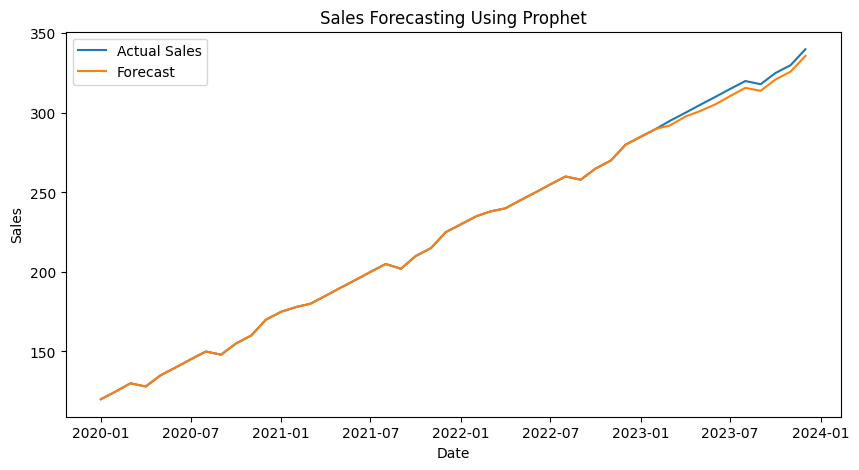

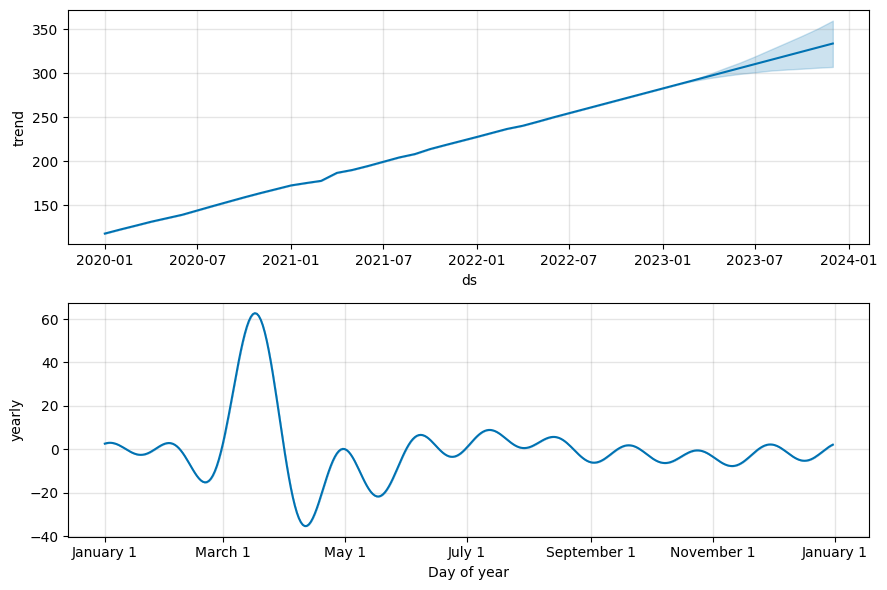

✅ Power BI–ready CSV files exported


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


# -----------------------------
# Load & Prepare Data
# -----------------------------
def load_data(filepath):
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"])
    return df


def prepare_prophet_data(df):
    return df.rename(columns={
        "date": "ds",
        "sales": "y"
    })


# -----------------------------
# Train Prophet Model
# -----------------------------
def train_model(train_df):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.fit(train_df)
    return model


# -----------------------------
# Forecast
# -----------------------------
def make_forecast(model, periods):
    future = model.make_future_dataframe(periods=periods, freq="MS")
    forecast = model.predict(future)
    return forecast


# -----------------------------
# Evaluation (Train-Test Split)
# -----------------------------
def evaluate_model(df):
    split = int(len(df) * 0.8)
    train = df.iloc[:split]
    test = df.iloc[split:]

    model = train_model(train)
    forecast = make_forecast(model, len(test))

    preds = forecast.set_index("ds")["yhat"].loc[test["ds"]]

    mae = mean_absolute_error(test["y"], preds)
    rmse = np.sqrt(mean_squared_error(test["y"], preds))

    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")

    return model, forecast


# -----------------------------
# Visualization
# -----------------------------
def plot_results(df, forecast, model):
    plt.figure(figsize=(10, 5))
    plt.plot(df["ds"], df["y"], label="Actual Sales")
    plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title("Sales Forecasting Using Prophet")
    plt.legend()
    plt.show()

    model.plot_components(forecast)
    plt.show()


# -----------------------------
# Export Power BI Ready CSVs
# -----------------------------
def export_powerbi_data(df, forecast):
    actuals = df.copy()
    actuals["type"] = "Actual"

    forecast_data = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    forecast_data.columns = ["ds", "y", "y_lower", "y_upper"]
    forecast_data["type"] = "Forecast"

    combined = pd.concat([actuals, forecast_data])
    combined = combined.sort_values("ds")

    actuals.to_csv("sales_actuals.csv", index=False)
    forecast_data.to_csv("sales_forecast.csv", index=False)
    combined.to_csv("sales_combined.csv", index=False)

    print("✅ Power BI–ready CSV files exported")


# -----------------------------
# Main Pipeline
# -----------------------------
def main():
    df = load_data("sales_data.csv")
    df_prophet = prepare_prophet_data(df)

    model, forecast = evaluate_model(df_prophet)

    plot_results(df_prophet, forecast, model)

    export_powerbi_data(df_prophet, forecast)


if __name__ == "__main__":
    main()
